# Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
import numpy as np
import polars as pl

In [2]:
# Load data.
data = pl.scan_csv('data/alpha_vals.csv', infer_schema_length=757)

# Compute provided output image for reference.

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# Get the output image and size.
# raw_out_colors = data.select("out_color_r", "out_color_g", "out_color_b")
ground_truth_image = Image.open("data/gt.png")
image_width, image_height = ground_truth_image.size

In [5]:
# Reshape the output colors to be displayed.
# out_colors_resized = raw_out_colors.collect().to_numpy().reshape(image_height, image_width, 3)

In [6]:
# Display it.
# plt.imshow(out_colors_resized)
# plt.axis('off')

# Cluster Splats.

In [7]:
# Number of clusters to use.
CLUSTERS = 5

In [8]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("pixelNum", "out_color_r", "out_color_g", "out_color_b", "bg_color_r", "bg_color_g",
                     "bg_color_b")).collect().to_numpy()
splats = raw_splats.reshape((image_height, image_width, raw_splats.shape[1] // 5, 5))


In [9]:
# Compute the minimum and maximum depth of the image.
depth_values = splats[:, :, :, 1]
depth_values = depth_values[depth_values > 0]
min_depth = np.min(depth_values)
max_depth = np.max(depth_values)

print(f"Min depth: {min_depth}, Max depth: {max_depth}")
print(f"Each bin will be {(max_depth - min_depth) / CLUSTERS} units wide.")

Min depth: 2.78219, Max depth: 9.9975
Each bin will be 1.443062 units wide.


In [10]:
from tqdm.contrib import itertools

In [11]:
# Cluster each splat into a bin (h x w x cluster x rgb, a, count).
clustered_splats = np.zeros((image_height, image_width, CLUSTERS, 5))

for i, j in itertools.product(range(image_height), range(image_width)):
    for splat in splats[i, j]:
        cluster_index = int((splat[1] - min_depth) / (max_depth - min_depth) * (CLUSTERS - 1))

        # Log alpha pre-multiplied color.
        clustered_splats[i, j, cluster_index, :3] += splat[2:] * splat[0]

        # Log alpha.
        clustered_splats[i, j, cluster_index, 3] += splat[0]

        # Log count.
        clustered_splats[i, j, cluster_index, 4] += 1

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [12]:
# Compute the color of each pixel using the clustered splats.
computed_image = np.zeros((image_height, image_width, 3))

for i, j in itertools.product(range(image_height), range(image_width)):
    transmittance = 1.0
    for k in range(CLUSTERS):
        # Skip if the alpha is zero.
        if clustered_splats[i, j, k, 3] == 0:
            continue
        # Skip if no splats in this cluster.
        if clustered_splats[i, j, k, 4] == 0:
            continue
        # Stop once transmittance is zero.
        if transmittance == 0:
            break
        
        # Compute the pixel color as the average of the summed colors.
        computed_image[i, j] += clustered_splats[i, j, k, :3] / clustered_splats[i, j, k, 4] * transmittance
        transmittance *= 1 - min(1, clustered_splats[i, j, k, 3])

  0%|          | 0/1051648 [00:00<?, ?it/s]

(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

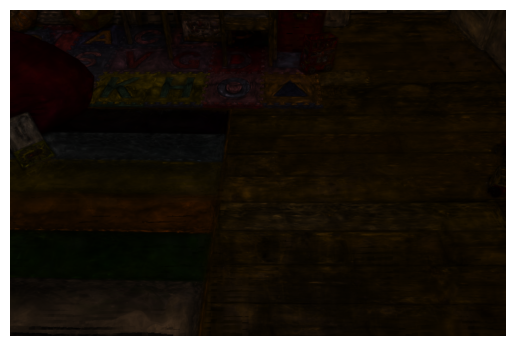

In [13]:
# Display the computed image.
plt.imshow(computed_image)
plt.axis('off')